# Demo 1: Funktionsweise von PINNs (Beispiel aus der Literatur)

In [1]:
import matplotlib.pyplot as plt
from spotpython.pinns.nn.fcn import FCN
from spotpython.pinns.plot.result import plot_result
import pickle
import numpy as np
import torch
from typing import Tuple

# 1 Die Differentialgleichung

$$
\frac{dy}{dt} + 0.1 y - \sin\left(\frac{\pi t}{2}\right) = 0
$$
mit Anfangswert
$$
y(0) = 0
$$.

# 2 Das Neuronales Netz

In [2]:
torch.manual_seed(123)
model = FCN(N_INPUT=1,
            N_OUTPUT=1,
            N_HIDDEN=32,
            N_LAYERS=3)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)

# 3 Die gemessenen Daten

In [3]:
def oscillatorb(n_steps: int = 3000,
                t_min: float = 0.0,
                t_max: float = 30.0,
                y0: float = 1.0,
                alpha: float = 0.1,
                omega: float = np.pi / 2) -> Tuple[torch.Tensor, torch.Tensor]:
    t_step = (t_max - t_min) / n_steps  # Time step
    # Time points: t_min, t_min + t_step, ..., t_min + (n_steps-1)*t_step
    t_points = np.arange(t_min, t_min + n_steps * t_step, t_step)[:n_steps]

    y = [y0]  # List to store y values, starting with initial condition

    # Solve for the time evolution
    # t_points[0] corresponds to y0. Loop starts from t_points[1].
    for t_current_step_end in t_points[1:]:
        # t_midpoint is the midpoint of the current integration interval
        # Interval: [t_current_step_end - t_step, t_current_step_end]
        # Midpoint: (t_current_step_end - t_step) + t_step/2 = t_current_step_end - t_step/2
        t_midpoint = t_current_step_end - t_step / 2.0
        # y_prev is the last computed value of y
        y_prev = y[-1]

        # Stage 1: Calculate intermediate y value (y_intermediate)
        # Uses slope at t_midpoint, with y_prev
        # f(t,y) = -alpha*y + sin(omega*t)
        slope_at_t_mid_using_y_prev = -alpha * y_prev + np.sin(omega * t_midpoint)
        y_intermediate = y_prev + (t_step / 2.0) * slope_at_t_mid_using_y_prev

        # Stage 2: Calculate y at t_current_step_end
        # Uses slope at t_current_step_end, with y_intermediate
        slope_at_t_end_using_y_intermediate = -alpha * y_intermediate + np.sin(omega * t_current_step_end)
        y_next = y_prev + t_step * slope_at_t_end_using_y_intermediate
        y.append(y_next)

    t_points_tensor = torch.tensor(t_points, dtype=torch.float32).view(-1, 1)
    y_values_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    return t_points_tensor, y_values_tensor

In [4]:
x, y = oscillatorb()
x_data=x[0:3000:119]
y_data=y[0:3000:119]

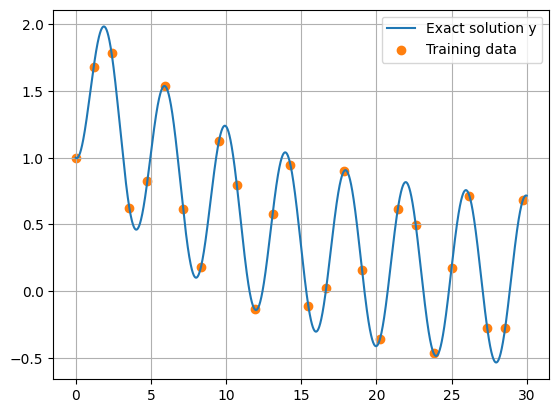

In [5]:
plt.figure()
plt.plot(x, y, label="Exact solution y")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.grid()
plt.show()

# 4 Die "Collocation" Punkte

In [6]:
x_physics = torch.linspace(0,30,50).view(-1,1).requires_grad_(True)

# 5 Die vom NN an den Punkten der physikalischen Daten vorhergesagten Werte

```python
yh = model(x_data)

# 6 Der mit den unter Punkt 5 gewonnenen NN-Vorhersagen berechnete Fehler (Loss1)

```python
loss1 = torch.mean((yh-y_data)**2)

# 7 Die an den Collocation-Punkten vorhergesagten Werte

```python
yhp = model(x_physics)

# 8 Die in den Collocation-Punkten berechneten Ableitungen für die DGL

```python
dyhp_dxphysics = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]

# 9 Die mit den Ableitungen aus Punkt 8 approximierrte DGL und der daraus berechnete Loss2

```python
physics = (dyhp_dxphysics + 0.1 * yhp - torch.sin(np.pi * x_physics/2))
loss2 = torch.mean(physics**2)

# 10 Der gesamte Loss

```python
loss = loss1 + alpha * loss2

In [7]:
loss_history_pinn = []
loss2_history_pinn = []
plot_data_points_pinn = []

alpha = 6e-2
for i in range(48000):
    optimizer.zero_grad()

    # We compute the "data loss"
    yh = model(x_data)
    loss1 = 1.*torch.mean((yh-y_data)**2)# use mean squared error

    # We compute the "physics loss"
    yhp = model(x_physics)
    dyhp_dxphysics = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    physics = (dyhp_dxphysics + 0.1*yhp - torch.sin(np.pi*x_physics/2))
    loss2 = torch.mean(physics**2)

    # We backpropagate total loss
    loss = loss1 + alpha * loss2
    loss.backward()
    optimizer.step()

    # We store data for plotting at specified intervals
    if (i+1) % 100 == 0:
        loss_history_pinn.append(loss.detach())
        loss2_history_pinn.append(loss2.detach())

        if (i+1) % 10000 == 0:
            current_yh_full = model(x).detach()
            plot_data_points_pinn.append({'yh': current_yh_full, 'step': i+1})

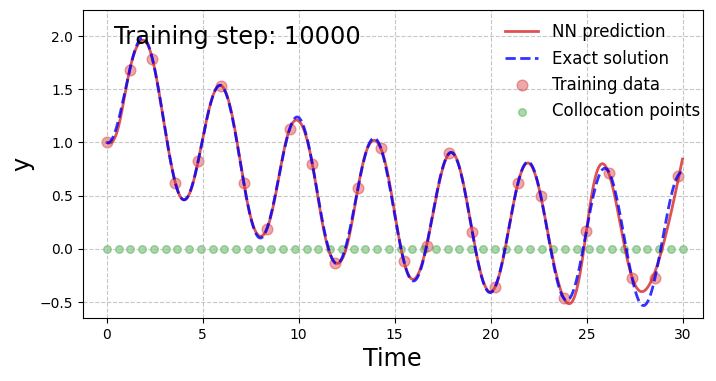

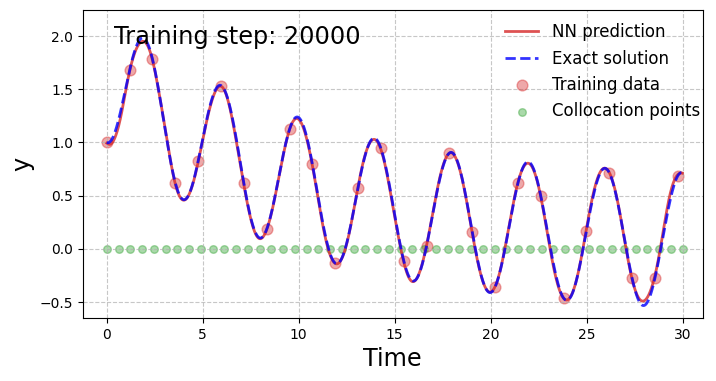

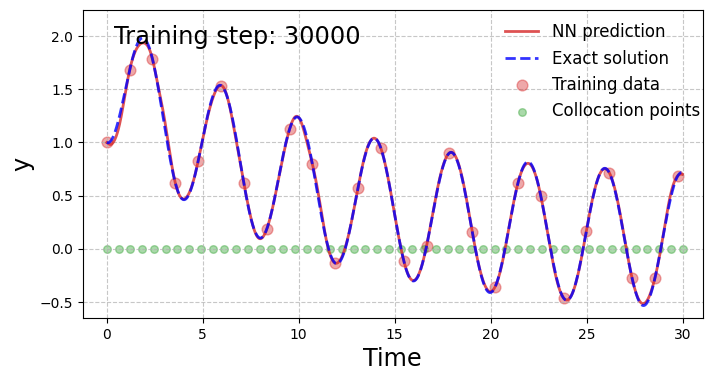

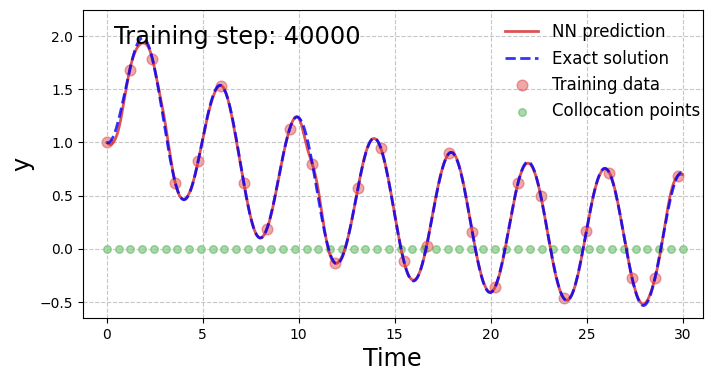

In [8]:
xp_plot_pinn = x_physics.detach()
for plot_info in plot_data_points_pinn:
    plot_result(x=x, y=y, x_data=x_data, y_data=y_data,
                yh=plot_info['yh'], xp=xp_plot_pinn,
                current_step=plot_info['step'], show_plot=True)